# Assignment 3.3

# Image Caption Retrieval Model

### 1. Data preprocessing

We will use Microsoft COCO (Common Objects in Context) data set to train our "Image Caption Retrieval Model". This data set consists of pretrained 10-crop VGG19 features (Neural codes) and its corresponding text caption. 


In [0]:
from __future__ import print_function

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import OrderedDict

DATA_PATH = 'data'
EMBEDDING_PATH = 'embeddings'
MODEL_PATH = 'models'

You will need to create above directories and locate data set provided in directory 'data'

In [55]:
# Download main dataset
!mkdir -p embeddings
!mkdir -p models

!wget https://storage.googleapis.com/trl_data/img_cap_coco.zip
!unzip img_cap_coco.zip 
!mv img_cap_coco data
!ls

--2018-04-15 21:18:38--  https://storage.googleapis.com/trl_data/img_cap_coco.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.197.128, 2607:f8b0:400e:c03::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.197.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 251061503 (239M) [application/zip]
Saving to: ‘img_cap_coco.zip.2’

img_cap_coco.zip.2  100%[===================>] 239.43M   108MB/s    in 2.2s    

2018-04-15 21:18:41 (108 MB/s) - ‘img_cap_coco.zip.2’ saved [251061503/251061503]

Archive:  img_cap_coco.zip
   creating: img_cap_coco/
  inflating: img_cap_coco/captions_val2014.json  
  inflating: img_cap_coco/instances_val2014.json  
  inflating: img_cap_coco/test_data.npy  
  inflating: img_cap_coco/train_data.npy  
  inflating: img_cap_coco/val_data.npy  
mv: cannot move 'img_cap_coco' to 'data/img_cap_coco': Directory not empty
data	    glove	  img_cap_coco.zip    models
datalab     glove.6B.zip  img_cap_c

In [56]:
!wget http://images.cocodataset.org/zips/val2014.zip
!unzip -q val2014.zip
!ls

--2018-04-15 21:18:53--  http://images.cocodataset.org/zips/val2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 74.125.197.128, 2607:f8b0:400e:c03::80
Connecting to images.cocodataset.org (images.cocodataset.org)|74.125.197.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6645013297 (6.2G) [application/zip]
Saving to: ‘val2014.zip.1’

val2014.zip.1        96%[==================> ]   6.00G   143MB/s    eta 2s     

val2014.zip.1       100%[===================>]   6.19G   142MB/s    in 44s     

2018-04-15 21:19:38 (143 MB/s) - ‘val2014.zip.1’ saved [6645013297/6645013297]

replace val2014/COCO_val2014_000000324670.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C
data	    glove	  img_cap_coco.zip    models	   val2014.zip.1
datalab     glove.6B.zip  img_cap_coco.zip.1  val2014
embeddings  img_cap_coco  img_cap_coco.zip.2  val2014.zip


#### Reading pairs of image (VGG19 features) - caption data

In [0]:
# DO NOT CHANGE BELOW CODE

import collections

np_train_data = np.load(os.path.join(DATA_PATH, 'train_data.npy'))
np_val_data = np.load(os.path.join(DATA_PATH, 'val_data.npy'))

train_data = collections.OrderedDict()
for i in range(len(np_train_data.item())):
    cap =  np_train_data.item()['caps']
    img =  np_train_data.item()['ims']
    train_data['caps'] = cap
    train_data['ims'] = img
    
val_data = collections.OrderedDict()
for i in range(len(np_val_data.item())):
    cap =  np_val_data.item()['caps']
    img =  np_val_data.item()['ims']
    val_data['caps'] = cap
    val_data['ims'] = img

In [58]:
# example of caption
train_data['caps'][0]

b'a woman wearing a net on her head cutting a cake'

In [59]:
# example of pre-computed VGG19 features. It is a 4096-embedding
val_data['ims'][0]

array([0.00109166, 0.        , 0.        , ..., 0.        , 0.        ,
       0.        ], dtype=float32)

In [60]:
print("Len of train caps:", len(train_data['caps']))
print("Shape of train ims:", train_data['ims'].shape)

print("\nLen of validation caps:", len(val_data['caps']))
print("Shape of validation ims:", val_data['ims'].shape)

Len of train caps: 50000
Shape of train ims: (10000, 4096)

Len of validation caps: 25000
Shape of validation ims: (5000, 4096)


#### Reading caption and information about its corresponding raw images from Microsoft COCO website

In [0]:
# DO NOT CHANGE BELOW CODE
# use them for your own additional preprocessing step
# to map precomputed features and location of raw images 

import json

with open(os.path.join(DATA_PATH, 'instances_val2014.json')) as json_file:
    coco_instances_val = json.load(json_file)
    
with open(os.path.join(DATA_PATH, 'captions_val2014.json')) as json_file:
    coco_caption_val = json.load(json_file)

In [62]:
print("Keys of coco_instances_val: ")
print(coco_instances_val.keys())
print("Keys of coco_caption_val:")
print(coco_caption_val.keys())

Keys of coco_instances_val: 
dict_keys(['info', 'images', 'licenses', 'annotations', 'categories'])
Keys of coco_caption_val:
dict_keys(['info', 'images', 'licenses', 'annotations'])


In [63]:
key = 'images'
type(coco_instances_val[key]) # list
print("Size of the list images is: ", len(coco_instances_val[key]))
type(coco_instances_val[key][0]) # dict
print("Each image in coco_instances_val contains:")
print(coco_instances_val[key][0].keys()) # id and file_name

print("")

type(coco_caption_val[key]) # list
print("Size of the list images is: ", len(coco_caption_val[key]))
type(coco_caption_val[key][0]) # dict
print("Each image in coco_caption_val contains:")
print(coco_caption_val[key][0].keys()) # id and file_name

print("\nIs size of lists equal?", len(coco_caption_val[key]) == len(coco_instances_val[key]) )

Size of the list images is:  40504
Each image in coco_instances_val contains:
dict_keys(['license', 'file_name', 'coco_url', 'height', 'width', 'date_captured', 'flickr_url', 'id'])

Size of the list images is:  40504
Each image in coco_caption_val contains:
dict_keys(['license', 'file_name', 'coco_url', 'height', 'width', 'date_captured', 'flickr_url', 'id'])

Is size of lists equal? True


In [64]:
key = 'annotations'
type(coco_instances_val[key]) # list
print("Size of the list annotations is: ", len(coco_instances_val[key]))
type(coco_instances_val[key][0]) # dict
print("Each annotation in coco_instances_val contains:")
print(coco_instances_val[key][0].keys()) # id and file_name

print("")

type(coco_caption_val[key]) # list
print("Size of the list annotations is: ", len(coco_caption_val[key]))
type(coco_caption_val[key][0]) # dict
print("Each annotation in coco_caption_val contains:")
print(coco_caption_val[key][0].keys()) # id and file_name

print("\nIs size of lists equal?", len(coco_caption_val[key]) == len(coco_instances_val[key]) )

Size of the list annotations is:  291875
Each annotation in coco_instances_val contains:
dict_keys(['segmentation', 'area', 'iscrowd', 'image_id', 'bbox', 'category_id', 'id'])

Size of the list annotations is:  202654
Each annotation in coco_caption_val contains:
dict_keys(['image_id', 'id', 'caption'])

Is size of lists equal? False


#### Additional preprocessing

In [0]:
import re

# This functions makes simple pre-processing of the text. It preserves words and
# spaces only and trims the resultant string.
def regularize_string(text):
  res = text.lower()
  res = re.sub(r'[^\w\s]','', res)
  res = res.strip()
  return res
  

In [0]:
# In this cell we create a dictionario of captions -> img_id
# This help us to get the image id by caption text for the requested function.

annotations = coco_caption_val['annotations']

cap_dict = dict()

for element in annotations:
  img_id = element['image_id']

  # Regularize caption string
  img_caption = regularize_string(element['caption'])
  cap_dict[img_caption] = img_id


In [67]:
# Visualizing our dict
cap_dict

{'a bicycle replica with a clock as the front wheel': 203564,
 'a black honda motorcycle parked in front of a garage': 179765,
 'a room with blue walls and a white sink and door': 322141,
 'a car that seems to be parked illegally behind a legally parked car': 16977,
 'a large passenger airplane flying through the air': 106140,
 'there is a gol plane taking off in a partly cloudy sky': 106140,
 'blue and white color scheme in a small bathroom': 322141,
 'this is a blue and white bathroom with a wall sink and a lifesaver on the wall': 322141,
 'a blue boat themed bathroom with a life preserver on the wall': 322141,
 'the bike has a clock as a tire': 203564,
 'a honda motorcycle parked in a grass driveway': 179765,
 'two cars parked on the sidewalk on the street': 16977,
 'an airplane that is either landing or just taking off': 106140,
 'a bathroom with walls that are painted baby blue': 322141,
 'a bathroom with a toilet sink and shower': 421676,
 'a long empty minimal modern skylit home

In [0]:
# In this cell we create a dictionario of img_id's and filepaths

relative_path = "val2014"
FILE_DELIMITER = "/"

img_path_index = dict() # [id, path]
for element in coco_instances_val['images'] :
  img_id = fName = element['id']
  fName = element['file_name']
  path = relative_path + FILE_DELIMITER + fName
  img_path_index[img_id] = path

In [69]:
# create your own function to map pairs of precomputed features and filepath of raw images
# this will be used later for visualization part
# simple approach: based on matched text caption (see json file)


# Create lookup table for train set. Each image has 5 captions and in this cell
# we associate each img in the features table (img_index) with its 5 captions,
# its path and its original img_id. 
# It comes important to note that some captions do not have information in the
# capt_dict, hence we set that to None.
train_lookup_table = []
img_index = -1
error_flag = False
errors = 0
for index, cap in enumerate(train_data['caps']):

  if index % 5 == 0: # Each 5 captions, we move to the next image
    if error_flag:
      errors += 1
#       print("Couldn't get data for index", str(index - 1))
#       print(current_cap)
    error_flag = False
    img_index += 1
    train_lookup_table.append( {'img_id' : None, 
                                'path' : None, 
                                'captions' : [] 
                               } )
  
  current_cap = regularize_string(cap.decode())
  img_id = cap_dict.get(current_cap)
  if img_id :
    path = img_path_index[img_id]

    train_lookup_table[img_index]['img_id'] = img_id
    train_lookup_table[img_index]['path'] = path
    train_lookup_table[img_index]['captions'].append(current_cap)
  else :
    
    error_flag = True
    
print("Number of missing elements : {} out of {}".format(errors, index))

Number of missing elements : 988 out of 49999


In [134]:
# Create lookup table for validation set
val_lookup_table = []
img_index = -1
error_flag = False
errors = 0
for index, cap in enumerate(val_data['caps']):

  if index % 5 == 0: # Each 5 captions, we move to the next image
    if error_flag:
      errors += 1
#       print("Couldn't get data for index", str(index - 1))
    error_flag = False
    img_index += 1
    val_lookup_table.append( {'img_id' : None, 
                                'path' : None, 
                                'captions' : [] 
                               } )
  
  current_cap = regularize_string(cap.decode())
  img_id = cap_dict.get(current_cap)
  if img_id :
    path = img_path_index[img_id]

    val_lookup_table[img_index]['img_id'] = img_id
    val_lookup_table[img_index]['path'] = path
    val_lookup_table[img_index]['captions'].append(current_cap)
  else :
    
    error_flag = True
    
print("Number of missing elements : {} out of {}".format(errors, index))

Number of missing elements : 481 out of 24999


In [71]:
# Quick look to our lookup table
val_lookup_table[0]

{'captions': ['a child holding a flowered umbrella and petting a yak',
  'a young man holding an umbrella next to a herd of cattle',
  'a young boy barefoot holding an umbrella touching the horn of a cow',
  'a young boy with an umbrella who is touching the horn of a cow',
  'a boy holding an umbrella while standing next to livestock'],
 'img_id': 184613,
 'path': 'val2014/COCO_val2014_000000184613.jpg'}

#### Build vocabulary index 

In [72]:
# DO NOT CHANGE BELOW CODE

def build_dictionary(text):

    wordcount = OrderedDict()
    for cc in text:
        words = cc.split()
        for w in words:
            if w not in wordcount:
                wordcount[w] = 0
            wordcount[w] += 1
    words = list(wordcount.keys())
    freqs = list(wordcount.values())
    sorted_idx = np.argsort(freqs)[::-1]
    

    worddict = OrderedDict()
    worddict['<pad>'] = 0
    worddict['<unk>'] = 1
    for idx, sidx in enumerate(sorted_idx):
        worddict[words[sidx]] = idx+2  # 0: <pad>, 1: <unk>
    

    return worddict

# use the resulting vocabulary index as your look up dictionary
# to transform raw text into integer sequences

all_captions = []
all_captions = train_data['caps'] + val_data['caps']

# decode bytes to string format
caps = []
for w in all_captions:
    caps.append(w.decode())
    
words_indices = build_dictionary(caps)
vocabulary_size = len(words_indices)
print ('Dictionary size: ' + str(vocabulary_size))
indices_words = dict((v,k) for (k,v) in words_indices.items())


Dictionary size: 11473


### 2. Image - Caption Retrieval Model

In [0]:
from keras.applications.vgg19 import VGG19
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout, Dot, GRU

# Set the dimension of the resulting image- caption representation to 1024.
units_output = 1024

### Image model

In [0]:
# YOUR CODE HERE 

# feature extractor model as described in the paper
image_input = Input(shape=(train_data['ims'].shape[1],), name = "img_input")
image_dense = Dense(units_output, activation = 'tanh', name = "img_dense")
image_pipeline = image_dense(image_input)

### Caption model

In [75]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip
!mkdir -p glove
!mv glove*txt glove/. 

--2018-04-15 21:24:22--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2018-04-15 21:24:22--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove.6B.zip.1      100%[===================>] 822.24M  92.5MB/s    in 9.1s    

2018-04-15 21:24:31 (90.4 MB/s) - ‘glove.6B.zip.1’ saved [862182613/862182613]

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [76]:
EMBEDDING_DIM = 300

embeddings_index = {}
f = open(os.path.join("glove", 'glove.6B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


embedding_matrix = np.zeros((vocabulary_size + 1, EMBEDDING_DIM))
for word, i in words_indices.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


In [0]:
# YOUR CODE HERE
MAX_SEQUENCE_LENGTH = 50

# For embedding layer, initialize with pretrained word embedding (GloVe)
caption_input = Input(shape=(MAX_SEQUENCE_LENGTH,), name = "cap_input")

caption_embedding = Embedding(vocabulary_size + 1, EMBEDDING_DIM, 
                              input_length = MAX_SEQUENCE_LENGTH, 
                              weights = [embedding_matrix])
caption_rnn = GRU(units_output)

caption_pipeline = caption_rnn(caption_embedding(caption_input))

# Noise model
noise_input = Input(shape=(MAX_SEQUENCE_LENGTH,)) # Same than caption, but representing noise
noise_pipeline = caption_rnn(caption_embedding(noise_input))

### Join model

In [0]:
# YOUR CODE HERE
from keras.layers.merge import dot, concatenate

positive_pair = dot([image_pipeline, caption_pipeline], axes = 0, 
                    name = "img_cap_enc_pos") # check if it should be axes=1

negative_pair = dot([image_pipeline, noise_pipeline], axes = 0, 
                    name = "img_cap_enc_neg") 

output = concatenate([positive_pair, negative_pair], name = "img_cap_output")


### Main model for training stage

In [79]:
# YOUR CODE HERE

# define your model input and output
print ("loading the training model")
training_model = Model(input = [image_input, caption_input, noise_input], 
                       output = output)

loading the training model


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("im...)`
  This is separate from the ipykernel package so we can avoid doing imports until


In [80]:
# from keras.utils import plot_model
training_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cap_input (InputLayer)          (None, 50)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
img_input (InputLayer)          (None, 4096)         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 50, 300)      3442200     cap_input[0][0]                  
                                                                 input_2[0][0]                    
__________

### Retrieval model

In [81]:
# YOUR CODE HERE

# define your model input and output

print ("loading sub-models for retrieving Neural codes")
image_model = Model(input = image_input, output = image_pipeline)
caption_model = Model(input = caption_input, output = caption_pipeline)


loading sub-models for retrieving Neural codes


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("im..., outputs=Tensor("im...)`
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("ca..., outputs=Tensor("gr...)`
  after removing the cwd from sys.path.


In [82]:
caption_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cap_input (InputLayer)       (None, 50)                0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 50, 300)           3442200   
_________________________________________________________________
gru_2 (GRU)                  (None, 1024)              4070400   
Total params: 7,512,600
Trainable params: 7,512,600
Non-trainable params: 0
_________________________________________________________________


In [83]:
image_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_input (InputLayer)       (None, 4096)              0         
_________________________________________________________________
img_dense (Dense)            (None, 1024)              4195328   
Total params: 4,195,328
Trainable params: 4,195,328
Non-trainable params: 0
_________________________________________________________________


### Loss function

We define our loss function as a loss for maximizing the margin between a positive and
negative example.  If we call $p_i$ the score of the positive pair of the $i$-th example, and $n_i$ the score of the negative pair of that example, the loss is:

\begin{equation*}
loss = \sum_i{max(0, 1 -p_i + n_i)}
\end{equation*}

In [0]:
from keras import backend as K
import tensorflow as tf


def max_margin_loss(y_true, y_pred):
    positive = y_pred[:,0]
    negative = y_pred[:,1]
    return K.sum(K.maximum(0., 1. - positive + negative))
   

#### Accuracy metric for max-margin loss
How many times did the positive pair effectively get a higher value than the negative pair?

In [0]:
# YOUR CODE HERE
def accuracy(y_true, y_pred):
    
    # YOUR CODE HERE
    positive = y_pred[:,0]
    negative = y_pred[:,1]
    return K.mean(positive > negative)


### Compile model

In [86]:
# DO NOT CHANGE BELOW CODE
print ("compiling the training model")
training_model.compile(optimizer='adam', loss=max_margin_loss, metrics=[accuracy])

compiling the training model


### 3. Data preparation for training the model

* adjust the length of captions into fixed maximum length (50 words)
* sampling caption for each image, while shuffling the image data
* encode captions into integer format based on look-up vocabulary index

In [0]:
# sampling one caption per image
# return image_ids, caption_ids

import random
from sklearn.utils import shuffle

def sampling_img_cap(data, lookup_table):
    img_ids = np.arange(len(data['ims']))
    caption_ids = []

    for i in img_ids:
      # sample random caption
      caption_start = i*5
      caption_index = caption_start #+ random.randint(0, 4)
      caption_ids.append(caption_index)
      
    # shuffle image data, together with its captions and its lookup table
    img_ids, caption_ids, lookup_table = shuffle(
          img_ids, np.asarray(caption_ids, dtype = np.int32), lookup_table)
    
    return img_ids.flatten(), caption_ids.flatten()

In [0]:
# Word to numbers

def sentece_to_int_seq(sentence):
  sequence = []
  for word in sentence.split() :
    number = words_indices.get(word)
    if number is None :
      number = words_indices.get('<unk>')
    sequence.append(number)
  
  if len(sequence) < MAX_SEQUENCE_LENGTH :
    remaining = MAX_SEQUENCE_LENGTH - len(sequence)
    sequence += [words_indices.get('<pad>')]*remaining
  return sequence[:50]


In [0]:
# transform raw text caption into integer sequences of fixed maximum length

def prepare_caption(caption_ids, caption_data):
    # YOUR CODE HERE
    
    caption_seqs = []
    my_captions = np.asarray(caption_data)[caption_ids]
    
    for caption in my_captions:    
      caption_seq = sentece_to_int_seq(caption)
      caption_seqs.append(caption_seq)
    
    return np.asarray(caption_seqs)

In [0]:
# DO NOT CHANGE BELOW CODE

train_caps = []
for cap in train_data['caps']:
    train_caps.append(cap.decode())

val_caps = []
for cap in val_data['caps']:
    val_caps.append(cap.decode())

In [0]:
# DO NOT CHANGE BELOW CODE

train_image_ids, train_caption_ids = sampling_img_cap(train_data, 
                                                      train_lookup_table)
val_image_ids, val_caption_ids = sampling_img_cap(val_data, val_lookup_table)

x_caption = prepare_caption(train_caption_ids, train_caps)
x_image = train_data['ims'][np.array(train_image_ids)]

x_val_caption = prepare_caption(val_caption_ids, val_caps)
x_val_image = val_data['ims'][np.array(val_image_ids)]


### 4. Create noise set for negative examples of image-fake caption and dummy output

Notice that we do not have real output with labels for training the model. Keras architecture expects labels, so we need to create dummy output -- which is numpy array of zeros. This dummy labels or output is never used since we compute loss function based on margin between positive examples (image-real caption) and negative examples (image-fake caption).

In [0]:
# YOUR CODE HERE

train_noise = np.copy(x_caption)
val_noise = np.copy(x_val_caption)

y_train_labels = np.zeros((len(train_data['ims']), 1))
y_val_labels = np.zeros((len(val_data['ims']), 1))


### 5. Training model

In [0]:
# YOUR CODE HERE

X_train = [x_image, x_caption, train_noise]
Y_train = y_train_labels
X_valid = [x_val_image, x_val_caption, val_noise]
Y_valid = y_val_labels

In [94]:
# YOUR CODE HERE

for epoch in range(10):
  np.random.shuffle(train_noise) # don’t forget to shuffle mismatched captions
  training_model.fit(X_train, Y_train, 
                     validation_data = [X_valid, Y_valid], epochs = 1, 
                     batch_size = 64)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Train on 10000 samples, validate on 5000 samples
Epoch 1/1
10000/10000 [==============================] - 61s 6ms/step - loss: 1024.4278 - accuracy: 0.4937 - val_loss: 1024.0000 - val_accuracy: 0.0000e+00
Train on 10000 samples, validate on 5000 samples
Epoch 1/1
10000/10000 [==============================] - 60s 6ms/step - loss: 954.6197 - accuracy: 0.5847 - val_loss: 1024.0000 - val_accuracy: 0.0000e+00
Train on 10000 samples, validate on 5000 samples
Epoch 1/1
 2240/10000 [=====>........................] - ETA: 41s - loss: 881.5296 - accuracy: 0.6448

10000/10000 [==============================] - 60s 6ms/step - loss: 788.2283 - accuracy: 0.7070 - val_loss: 1024.0000 - val_accuracy: 0.0000e+00
Train on 10000 samples, validate on 5000 samples
Epoch 1/1
10000/10000 [==============================] - 60s 6ms/step - loss: 594.5952 - accuracy: 0.8164 - val_loss: 1024.0000 - val_accuracy: 0.0000e+00
Train on 10000 samples, validate on 5000 samples
Epoch 1/1
 5312/10000 [==============>...............] - ETA: 24s - loss: 478.2059 - accuracy: 0.8568

10000/10000 [==============================] - 60s 6ms/step - loss: 453.8348 - accuracy: 0.8663 - val_loss: 1024.0000 - val_accuracy: 0.0000e+00
Train on 10000 samples, validate on 5000 samples
Epoch 1/1
10000/10000 [==============================] - 60s 6ms/step - loss: 145.9737 - accuracy: 0.9418 - val_loss: 1024.0000 - val_accuracy: 0.0000e+00
Train on 10000 samples, validate on 5000 samples
Epoch 1/1
 5888/10000 [================>.............] - ETA: 21s - loss: 26.9344 - accuracy: 0.9923

10000/10000 [==============================] - 60s 6ms/step - loss: 21.8880 - accuracy: 0.9934 - val_loss: 1024.0000 - val_accuracy: 0.0000e+00
Train on 10000 samples, validate on 5000 samples
Epoch 1/1
10000/10000 [==============================] - 60s 6ms/step - loss: 5.9717 - accuracy: 0.9979 - val_loss: 1024.0000 - val_accuracy: 0.0000e+00
Train on 10000 samples, validate on 5000 samples
Epoch 1/1
 6144/10000 [=================>............] - ETA: 20s - loss: 22.0891 - accuracy: 0.9931

10000/10000 [==============================] - 60s 6ms/step - loss: 16.1231 - accuracy: 0.9951 - val_loss: 1024.0000 - val_accuracy: 0.0000e+00
Train on 10000 samples, validate on 5000 samples
Epoch 1/1
10000/10000 [==============================] - 60s 6ms/step - loss: 1.8107 - accuracy: 0.9995 - val_loss: 1024.0000 - val_accuracy: 0.0000e+00


#### Storing models and weight parameters

In [0]:
# DO NOT CHANGE BELOW CODE

# Save model
training_model.save(os.path.join(MODEL_PATH,'image_caption_model.h5'))
# Save weight parameters
training_model.save_weights(os.path.join(MODEL_PATH, 'weights_image_caption.hdf5'))

# Save model for encoding caption and image
caption_model.save(os.path.join(MODEL_PATH,'caption_model.h5'))
image_model.save(os.path.join(MODEL_PATH,'image_model.h5'))

### 6. Feature extraction (Neural codes)

In [0]:
# YOUR CODE HERE

# Use caption_model and image_model to produce "Neural codes" 
# for both image and caption from validation set
caption_nc = caption_model.predict(x_val_caption)
image_nc = image_model.predict(x_val_image)

### 7. Caption Retrieval

#### Display original image as query and its ground truth caption

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing import image

In [0]:
def int_seq_to_sentence(sequence):
  
  sentence = ""
  for number in sequence:
    word = indices_words.get(number)
    if word == "<unk>" :
      word = "?"
    if word != "<pad>" :
      sentence += (word + " ")
  return sentence.strip() # trim the word


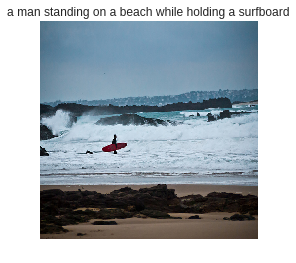

In [169]:
# YOUR CODE HERE

# choose one image_id from validation set
# use this id to get filepath of image
index = 860
img_id = val_lookup_table[index]['img_id']
filepath_image = val_lookup_table[index]['path']

# display original caption
original_caption = val_lookup_table[index]['captions'][0]

# DO NOT CHANGE BELOW CODE
img = image.load_img(os.path.join("", filepath_image), target_size=(224,224))
plt.imshow(img)
plt.title(original_caption)
plt.axis("off")
plt.show()

In [174]:
print(int_seq_to_sentence(x_val_caption[index]))

a train moving along a track during the day


In [0]:
# function to retrieve caption, given an image query

def get_caption(index, n = 10):   
  
  # YOUR CODE HERE
  # compute score of all captions in the dataset
  image_representation = image_model.predict( np.asarray([x_val_image[index]]) ) 
  scores = np.dot(caption_nc, image_representation.T).flatten()
  # compute indices of n best captions
  indices = np.argpartition(scores, -n)[-n:]
  indices = indices[np.argsort(scores[indices])] # display them
  for i in [int(x) for x in reversed(indices)]:
    print("{:.2f}\t{}".format(scores[i], int_seq_to_sentence(x_val_caption[i])))


In [171]:
# DO NOT CHANGE BELOW CODE
get_caption(index)

301.66	three passenger airplanes parked on a airport runway
298.85	theres a yellow fire hydrant with blue trim o ntop
298.63	two nypd motorcycles parked along a city street
298.49	a clock sitting in the middle of a parking lot
298.46	a clock sitting in the middle of the city in front of a building
298.27	a building sits in front of a parking meter
298.20	a train sitting in front of a tin building and a dry grass field
298.19	a street sign sitting in the middle of a road
298.19	a traffic signal sitting next to a street at night
298.14	a bus parked on top of a red bus


Briefly discuss the result. Why or how it works, and why do you think it does not work at some point.

#### Answer:

We can see that the retrieval process is showing some innacurate results, however this result may due to a mistake in our lookup tables, since as we see the lookup caption does not correspond to the real x_val_caption. However, by analyzing the accuracy of the captions retrieved, one can see that the result is not that accurate anyway. This may due to the fact that the length of the sequences is too big for the actual size of the captions and then results tend to be innacurate. 



### 8. Image Retrieval

In [0]:
# given text query, display retrieved image, similarity score, and its original caption 

def search_image(text_caption, n=10):
    caption_representation = caption_model.predict(np.asarray([sentece_to_int_seq(text_caption)])) 
    scores = np.dot(image_nc, caption_representation.T).flatten()
    indices = np.argpartition(scores, -n)[-n:] 
    indices = indices[np.argsort(scores[indices])] 
    fig, axes = plt.subplots(nrows = 1, ncols = 10)
    fig.set_size_inches(20, 30)
    count = 0
    for i in [int(x) for x in reversed(indices)]:
      img = image.load_img(os.path.join("", val_lookup_table[i]['path']), target_size=(224,224))
      axes[count].imshow(img)
      axes[count].set_title("Score : {:.2f}".format(scores[i]))
      axes[count].axis("off")
      count += 1
    plt.show()
    # YOUR CODE HERE
    

Consider to use the following settings for image retrieval task.

* use real caption that is available in validation set as a query.
* use part of caption as query. For instance, instead of use the whole text sentence of the
caption, you may consider to use key phrase or combination of words that is included in
corresponding caption.

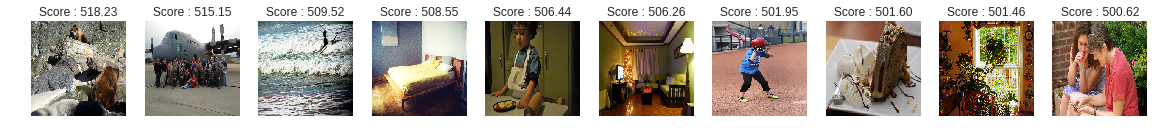

In [156]:
# Example of text query 
# text = 'two giraffes standing near trees'

# YOUR QUERY-1
text1 = 'a young boy with an umbrella who is touching the horn of a cow'

# DO NOT CHANGE BELOW CODE
search_image(text1)

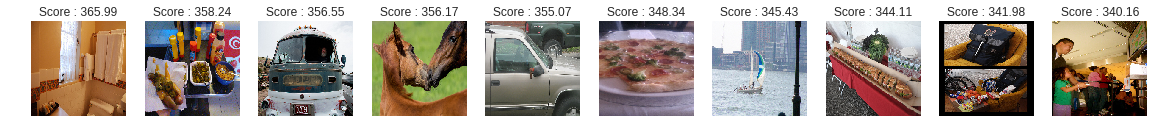

In [175]:
# YOUR QUERY-2
text2 = "room with blue walls "

# DO NOT CHANGE BELOW CODE
search_image(text2)

Briefly discuss the result. Why or how it works, and why do you think it does not work at some point.

#### Answer:

In the caption retrieval we can observe an improvement in the performance, for instance, in the first example we can observe results with boys in the picutre. On the other side, for the query 2 we observe that some objects with similar meaning are retrieved.

The first query is an exact text in the validation set and we see that the accuracy for that one is a bit better. We can argue that the model is still a bit innacurate for modifications in the text in the validation set.